In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 8

# Load data

In [4]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])
        
    

## Scale Inputs

In [5]:

# # concat flows
# scaled_flows = list(flows_dict.values())
# scaled_flows = pd.concat(scaled_flows, axis=0)

# # scaler = MinMaxScaler((-1,1))
# scaler = RobustScaler()
# scaler.fit(scaled_flows)
# scaled_flows = scaler.transform(scaled_flows)

# scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
# print(scaled_flows.shape)
# print(scaled_flows.head())

In [6]:
# concat flows
scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler = QuantileTransformer()
scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.833222     0.244391
1  0.002889  0.833121     0.245015
2  0.004004  0.833019     0.245379
3  0.005005  0.832918     0.245593
4  0.007007  0.832811     0.245811


# All Columns

In [7]:
# separate into file series
scaled_all = [scaled_flows.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows) // 640)]
scaled_all = [flow.values for flow in scaled_all]
scaled_all = np.array([flow.ravel() for flow in np.array(scaled_all)])
scaled_all.shape

(11771, 1920)

In [8]:
scaled_all[0][:20]

array([0.        , 0.83322177, 0.24439078, 0.00288919, 0.83312061,
       0.24501548, 0.00400402, 0.83301925, 0.24537932, 0.00500502,
       0.83291768, 0.24559302, 0.00700701, 0.83281075, 0.24581059,
       0.00800806, 0.83267777, 0.24603206, 0.00995357, 0.83254451])

## TSNE

In [9]:
tsne = TSNE(n_components=2)
transformed_all = tsne.fit_transform(scaled_all)
transformed_all.shape

(11771, 2)

<AxesSubplot: >

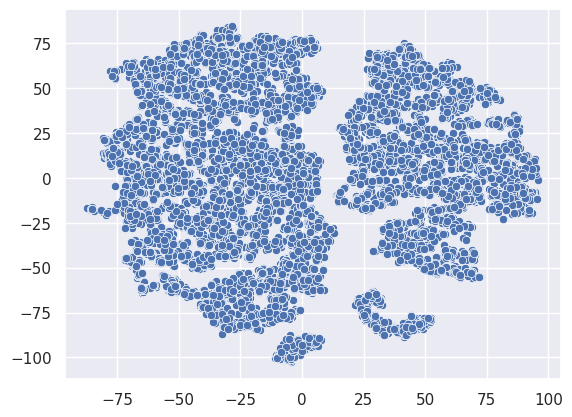

In [10]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

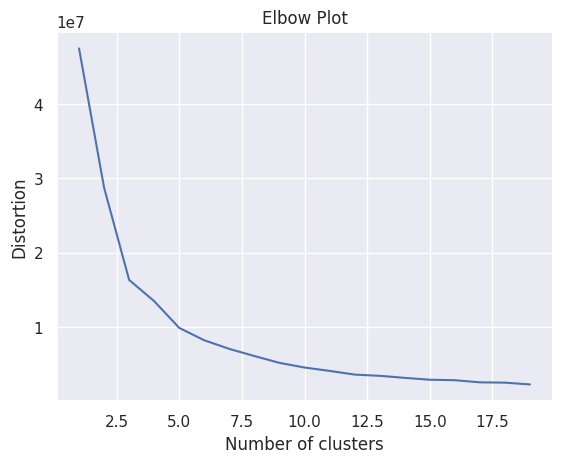

In [11]:
# Elbow Test
distortions = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_all)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [12]:
silhouette_scores = {"n_clusters" : [], "silhouette_score" : []}
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, max_iter=5000, n_init='auto')
    labels = kmeans.fit_predict(transformed_all)
    silhouette_avg = silhouette_score(transformed_all, labels)
    silhouette_scores["n_clusters"].append(i)
    silhouette_scores["silhouette_score"].append(silhouette_avg)
pd.DataFrame(silhouette_scores, index=None)    

,n_clusters,silhouette_score
0,2,0.384353
1,3,0.429333
2,4,0.388853
3,5,0.376123
4,6,0.392369
5,7,0.358397
6,8,0.385326
7,9,0.381933
8,10,0.394899
9,11,0.399574


In [13]:
kmeans = KMeans(n_clusters=3,max_iter=500, n_init='auto')
tsne_kmeans_labels = kmeans.fit_predict(scaled_all)
nclusters = len(set(tsne_kmeans_labels))

<AxesSubplot: >

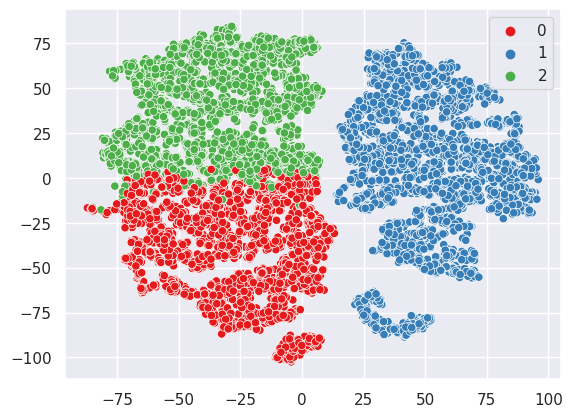

In [14]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=tsne_kmeans_labels, palette='Set1')

### Original Data

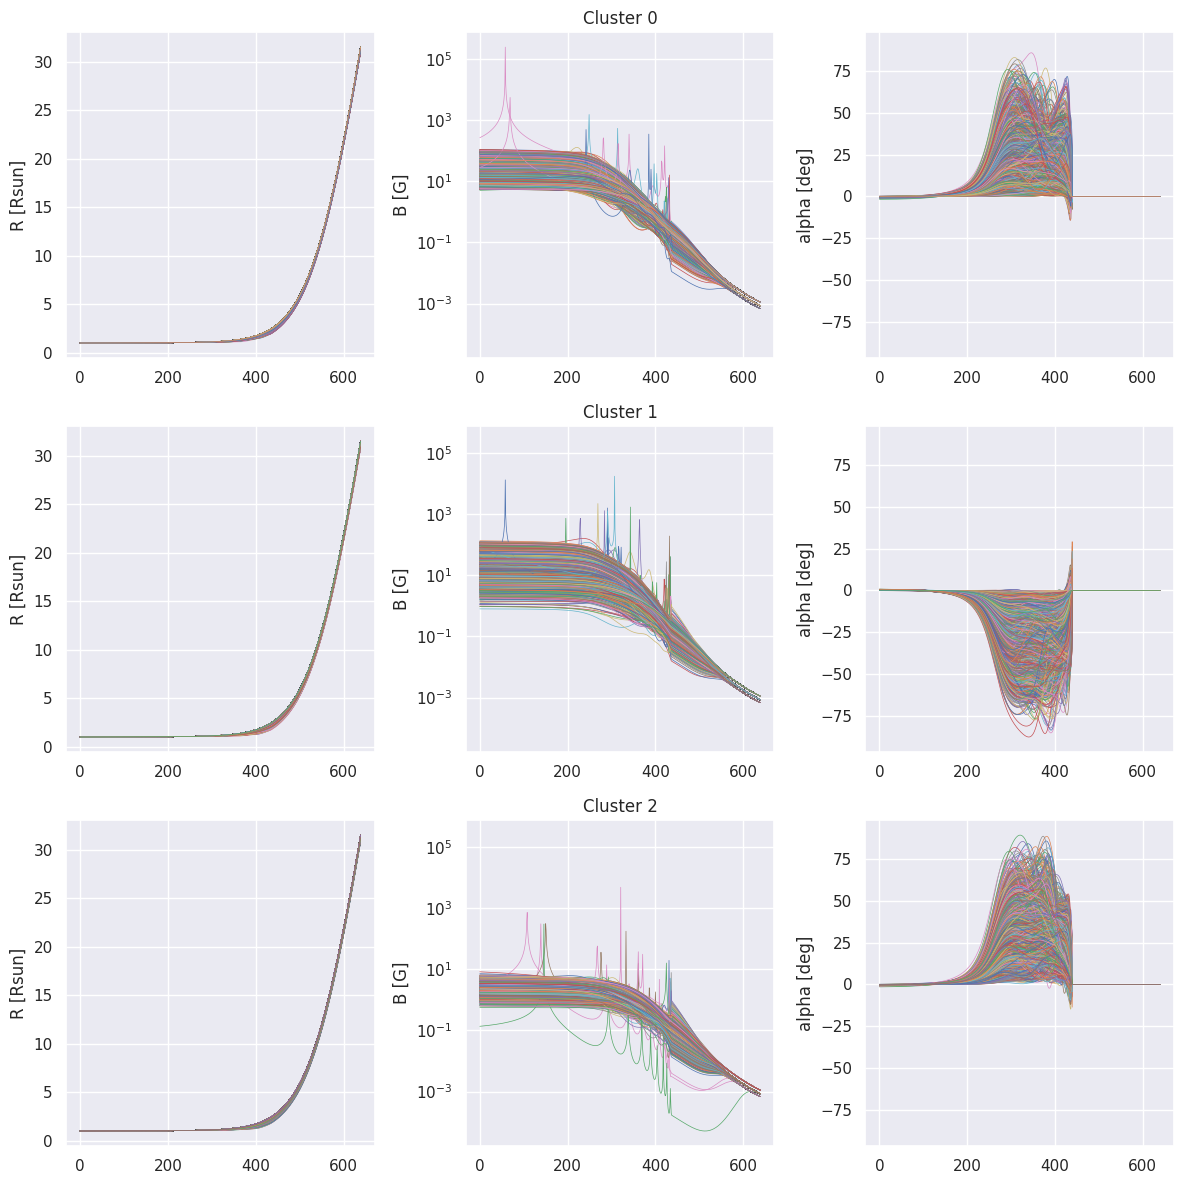

In [15]:
plot_unscaled_clusters(tsne_kmeans_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

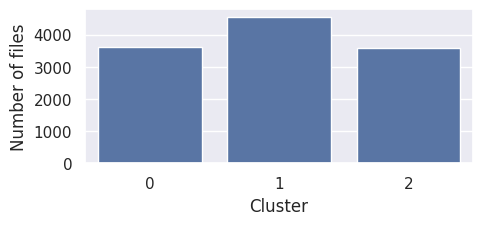

In [16]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=tsne_kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

{'CR1992': [1090, 1339, 71], 'CR2056': [750, 1298, 514], 'CR2071': [138, 1291, 744], 'CR2125': [638, 635, 790], 'CR2210': [1006, 0, 1467]}
[0, 1, 2]


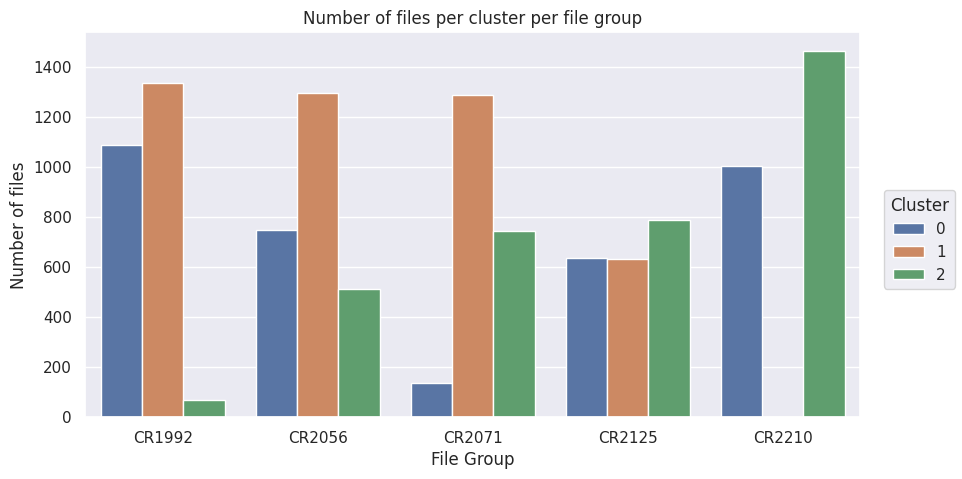

In [17]:
fig = plot_cluster_file_group(filenames, tsne_kmeans_labels, nclusters)

### Grid Search

In [15]:
# %%capture
# subdir = OUT_DIR / 'kmeans'
# if not subdir.exists():
#     subdir.mkdir(parents=True)
    
# for k in range(2, 5):
#     kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
#     kmeans_labels = kmeans.fit_predict(transformed_all)
    
#     sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=kmeans_labels, palette='Set1')
#     plt.savefig(subdir / f'scatter_{k}.png', dpi=200)
#     plot_unscaled_clusters(kmeans_labels, k, flows_dict, flow_columns, save_path=subdir / f'unscaled_{k}.png', yscale={'B [G]': 'log'})

## Hierarchical Clustering

In [18]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=2, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_all)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

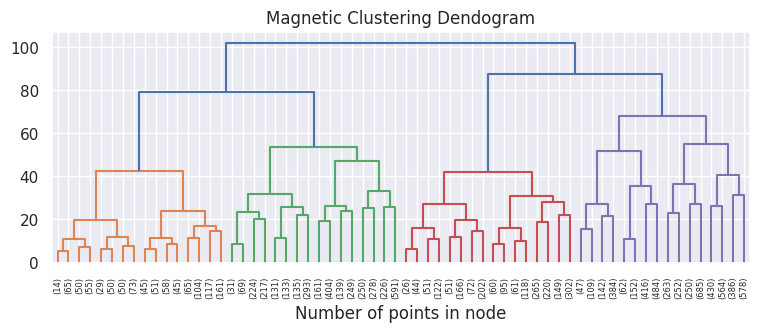

In [19]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=5)
plt.xlabel("Number of points in node")

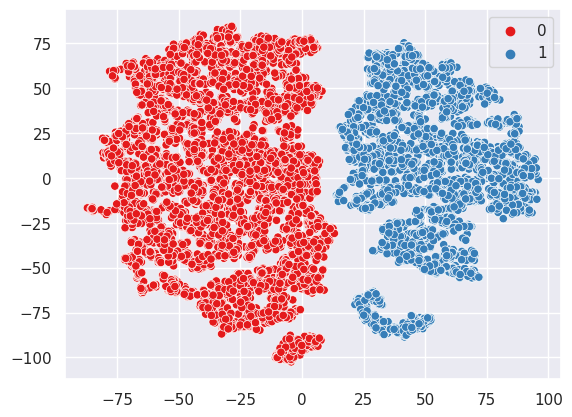

In [20]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

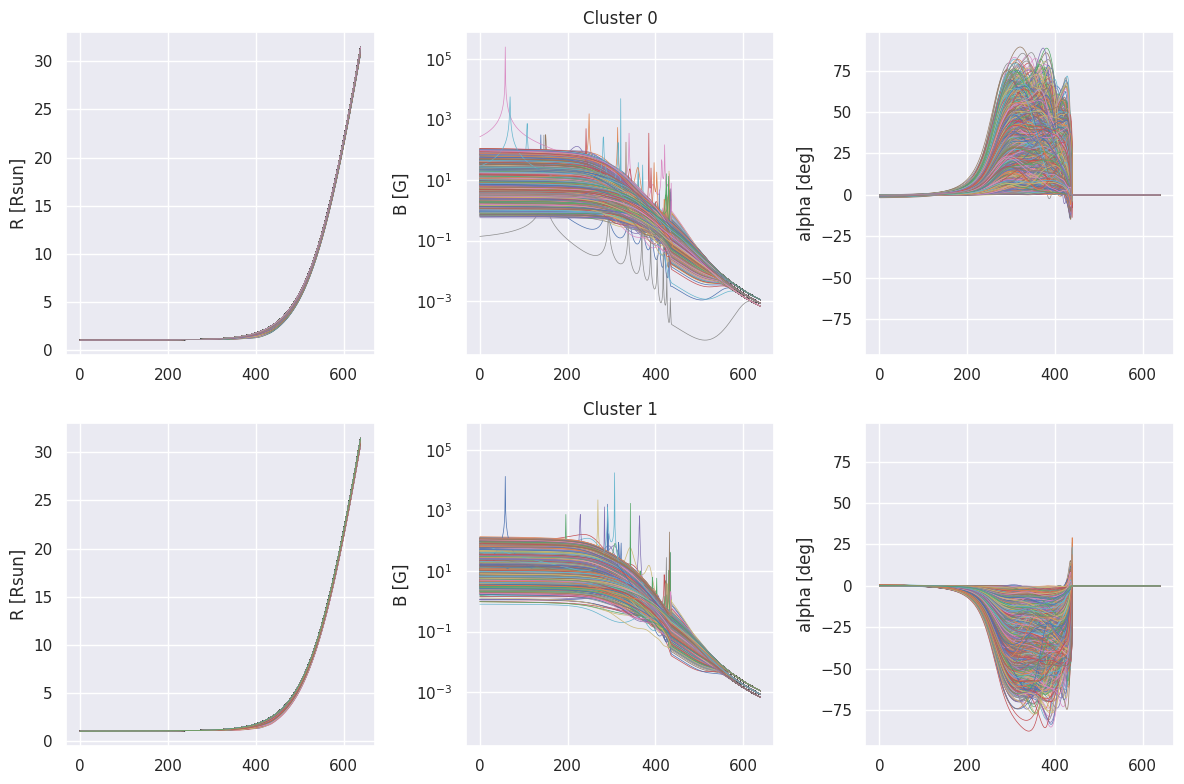

In [21]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

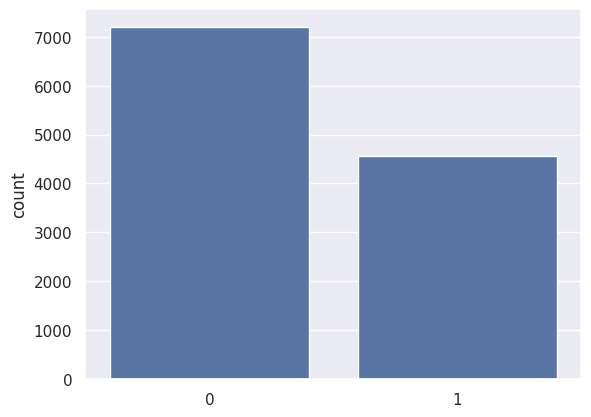

In [22]:
sns.countplot(x=agg.labels_, color='b')

{'CR1992': [1161, 1339], 'CR2056': [1264, 1298], 'CR2071': [882, 1291], 'CR2125': [1428, 635], 'CR2210': [2473, 0]}
[0, 1]


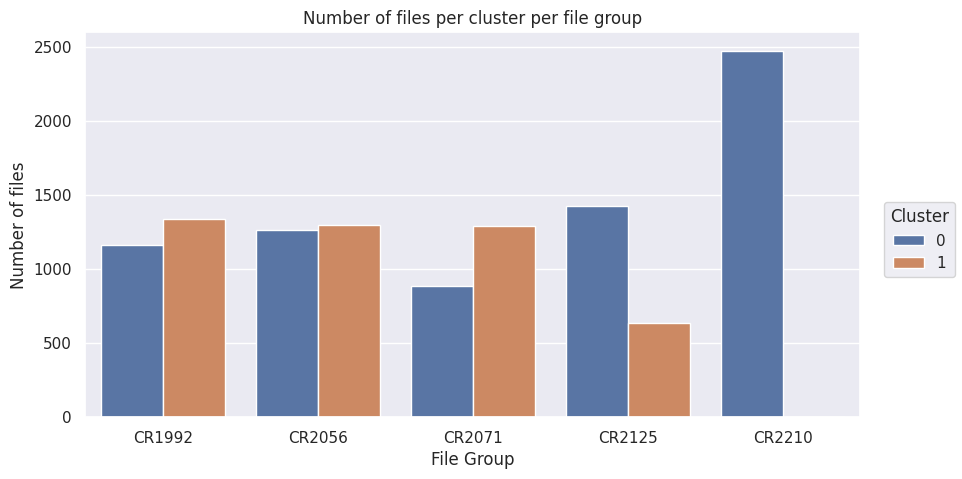

In [23]:
fig = plot_cluster_file_group(filenames, agg.labels_, nclusters)

### Grid Search

In [24]:
# %%capture
# sub_dir = OUT_DIR / 'hierarchical'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_all)
    
#     sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1') 
#     plt.savefig(sub_dir / f'scatter_{i}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, i, flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{i}.png', yscale={'B [G]': 'log'}) 
    